In [24]:
# Sentiment algorithm 1. Sequence of lemmas as single feature input and binary classification of sentence as output

In [25]:
# SETUP IMPORTS
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

import pandas as pd
import numpy as np
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.utils.vis_utils import plot_model
import time
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report
from collections import Counter
from keras.preprocessing.text import Tokenizer
from sklearn.preprocessing import LabelEncoder
from keras import models
import os
import time
import tensorflow as tf
from keras import callbacks
pd.set_option('display.max_columns', 10, 'display.width', 10, 'display.max_colwidth', 20, 'display.max_rows',100)

In [26]:
# LOAD DATASET
df = pd.read_json('../datasets/sentiment_corpus.json')
print("Corpus sample size is:", len(df))

training_size = 3000000
test_size = 1000000

print(training_size, "samples are taken from the head for training")
print(test_size, "samples are taken from the tail for test")

# We take from the head for training data and tail for test data
# This is done since the last 25% of the corpus is not fitted on the polarity dict, thereby preventing overfitting
train_data = df.head(training_size)
test_data = df.tail(test_size)

train_data

Corpus sample size is: 4970467
30000 samples are taken from the head for training
10000 samples are taken from the tail for test


,Sentence #,Word,Lemma,POS,Polarity,Gender
0,1,organizations,organization,NOUN,-0.223025,F
1,1,decided,decide,VERB,-0.039008,F
2,1,drop,drop,VERB,-0.058436,F
3,1,women,woman,NOUN,0.272143,F
4,1,accused,accuse,VERB,0.006282,F
...,...,...,...,...,...,...
29995,3967,reaction,reaction,NOUN,0.006468,F
29996,3968,insane,insane,ADJ,0.000000,F
29997,3968,cyberbullying,cyberbullying,NOUN,0.000000,F
29998,3968,said,say,VERB,-0.564779,F


In [27]:
# GROUP-BY SENTENCE NUMBER 
train_data = train_data.groupby(['Sentence #'],as_index=False)['Word', 'Lemma', 'POS', 'Polarity', 'Gender'].agg(lambda x: list(x))
test_data = test_data.groupby(['Sentence #'],as_index=False)['Word', 'Lemma', 'POS', 'Polarity', 'Gender'].agg(lambda x: list(x))

def gender_seq_to_single(seqs):
    genders = []
    for seq in seqs:
        genders.append(seq[0])
    return genders

train_data['Gender'] = gender_seq_to_single(train_data['Gender'])
test_data['Gender'] = gender_seq_to_single(test_data['Gender'])
train_data

C:\Users\hanse\AppData\Local\Temp/ipykernel_26800/2965456592.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  train_data = train_data.groupby(['Sentence #'],as_index=False)['Word', 'Lemma', 'POS', 'Polarity', 'Gender'].agg(lambda x: list(x))
C:\Users\hanse\AppData\Local\Temp/ipykernel_26800/2965456592.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  test_data = test_data.groupby(['Sentence #'],as_index=False)['Word', 'Lemma', 'POS', 'Polarity', 'Gender'].agg(lambda x: list(x))


,Sentence #,Word,Lemma,POS,Polarity,Gender
0,1,"[organizations, ...","[organization, d...","[NOUN, VERB, VER...",[-0.223024829414...,F
1,2,"[Women, previous...","[woman, previous...","[NOUN, ADV, VERB...",[0.2721428399909...,F
2,3,"[response, alleg...","[response, alleg...","[NOUN, NOUN, PRO...",[-0.028053754978...,F
3,4,"[aware, allegati...","[aware, allegati...","[ADJ, NOUN, PROPN]",[-0.015715441394...,F
4,5,"[point, Visa, su...","[point, Visa, su...","[NOUN, PROPN, VE...",[-0.228729956550...,F
...,...,...,...,...,...,...
3320,3965,"[People, didn, u...","[People, didn, u...","[NOUN, AUX, VERB...",[-0.027128857560...,F
3321,3966,"[article, inspir...","[article, inspir...","[NOUN, VERB, NOU...",[-0.054393432894...,F
3322,3967,"[said, unprepare...","[say, unprepared...","[VERB, ADJ, NOUN]",[-0.564778745996...,F
3323,3968,"[insane, cyberbu...","[insane, cyberbu...","[ADJ, NOUN, VERB]","[0.0, 0.0, -0.56...",F


<AxesSubplot:>

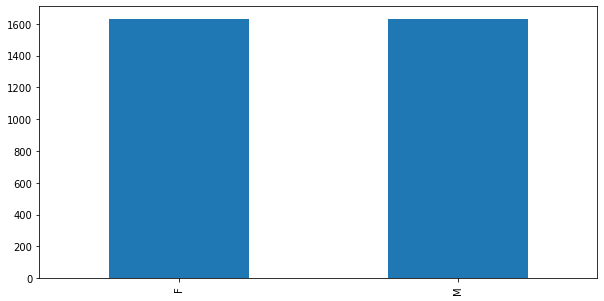

In [28]:
# EQUAL GENDER SAMPLES TO PREVENT BIAS
def equal_genders(data_):
    M, F = data_["Gender"].value_counts()
    if M>F:
        diff = M-F
        return data_.drop(data_.loc[data_['Gender'] == 'M'].index[:diff], axis=0)
    elif F>M:
        diff = F-M
        return data_.drop(data_.loc[data_['Gender'] == 'F'].index[:diff], axis=0)

train_data = equal_genders(train_data)
test_data = equal_genders(test_data)

train_data["Gender"].value_counts().plot(kind="bar", figsize=(10,5))

In [29]:
# SHUFFLE TRAINING AND TEST DATA
train_data = train_data.sample(frac=1).reset_index(drop=True)
test_data = test_data.sample(frac=1).reset_index(drop=True)
train_data

,Sentence #,Word,Lemma,POS,Polarity,Gender
0,3396,"[Hensarling, fou...","[Hensarling, fin...","[PROPN, VERB, NO...","[0.0, -0.1560668...",M
1,180,[said],[say],[VERB],[-0.564778745996...,M
2,3404,"[bill, crafted, ...","[bill, craft, Se...","[NOUN, VERB, PRO...",[-0.062610034209...,M
3,2077,"[saying, women, ...","[say, woman, wom...","[VERB, NOUN, NOU...",[-0.564778745996...,F
4,231,"[continue, conve...","[continue, conve...","[VERB, NOUN]",[-0.132061970609...,M
...,...,...,...,...,...,...
3251,2239,"[story, women, e...","[story, woman, e...","[NOUN, NOUN, VER...",[-0.016240737626...,F
3252,1108,"[bar, went, nuts...","[bar, go, nuts, ...","[NOUN, VERB, ADJ...",[-0.002733303678...,M
3253,2584,"[don, care, said]","[don, care, say]","[AUX, VERB, VERB]","[0.0, -0.0583723...",F
3254,3860,"[raped, MTC]","[rape, MTC]","[VERB, PROPN]",[0.1199767594677...,F


In [30]:
# DEFINE FUNCTION FOR PLOTTING SENTENCE LENGTHS
def plot_sentence_lengths(data_):
    sentence_plot = data_["Word"].values
    sentence_plot_sorted = list(sorted(sentence_plot, key=len))
    c = Counter(map(len, sentence_plot_sorted))

    total_sentences = 0
    total_words = 0
    for i in c:
        total_sentences = total_sentences + c[i]
        total_words = total_words + c[i]*i

    sentences_80_pct = total_sentences / 100 * 90
    words_80_pct = total_words / 100 * 90

    boundary_sen = 0
    counter_sen = 0

    for i in c:
        if(counter_sen + c[i] < int(sentences_80_pct)):
            counter_sen = counter_sen + c[i]
            boundary_sen = i
        else:
            break

    boundary_word = 0
    counter_word = 0

    for i in c:
        if(counter_word + c[i] * i < int(words_80_pct)):
            counter_word = counter_word + c[i] * i
            boundary_word = i
        else:
            break


    my_cmap = plt.get_cmap("viridis")
    rescale = lambda y: (y - np.min(y)) / (np.max(y) - np.min(y))


    plt.figure(figsize=[10,6])
    bars = plt.bar(list(c.keys()), list(c.values()), color=my_cmap(rescale(list(c.values()))), width=0.8, alpha=0.7, align='center')

    # for r in bars.get_children():
    #     if(r.get_x() > boundary_sen):
    #         r.set_alpha(0.2)

    plt.legend(loc="best")
    plt.ylim([0, max(list(c.values()))+10])
    ax2 = plt.gca()

    ymin, ymax = ax2.get_ylim()
    plt.vlines(boundary_sen, ymin=ymin, ymax=ymax, colors='r', label='80% of sentences')
    # plt.vlines(boundary_word, ymin=ymin, ymax=ymax, colors='black', label="80% of words")

    plt.ylabel('Frequency of sentence', fontdict={'fontsize':13, 'fontweight': 'bold'})
    plt.xlabel('# words in sentence', fontdict={'fontsize':13, 'fontweight': 'bold'})
    plt.title("Distribution of sentence lengths", fontdict={'fontsize':14, 'fontweight': 'bold'})
    plt.legend()
    plt.show()
    return boundary_sen

No handles with labels found to put in legend.


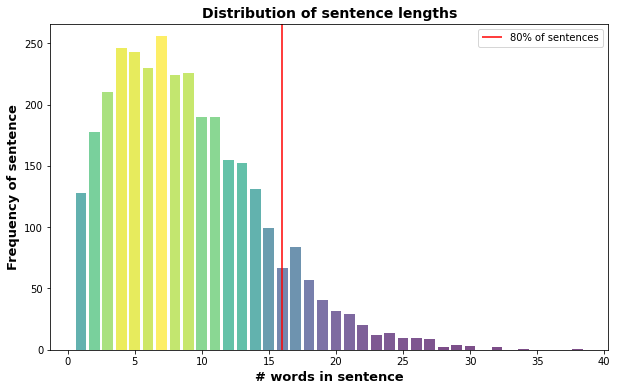

Decision boundary / 80 pct of sentence lengths is: 16


In [31]:
# VISUALIZE SENTENCE LENGTHS AND DECISION BOUNDARY
decision_boundary = plot_sentence_lengths(train_data)
print("Decision boundary / 80 pct of sentence lengths is:", decision_boundary)

In [32]:
# ENCODE FEATURES TO INTEGERS, EQUAL LENGTHS AND PAD
# Inspired by: https://machinelearningmastery.com/prepare-text-data-deep-learning-keras/
def encode_feature(train_data_, test_data_):
    tokenizer = Tokenizer()
    # ONLY FIT ON TRAIN DATA
    tokenizer.fit_on_texts(train_data_)
    return tokenizer.texts_to_sequences(train_data_), tokenizer.texts_to_sequences(test_data_), len(tokenizer.word_index)

train_data['Lemma_enc'], test_data['Lemma_enc'], vocab_size = encode_feature(train_data['Lemma'], test_data['Lemma'])


trunc_type = 'post'
padding_type = 'post'
max_len = decision_boundary

X_train = pad_sequences(train_data['Lemma_enc'], dtype='float32', padding=padding_type, truncating=trunc_type, maxlen=max_len)
X_test = pad_sequences(test_data['Lemma_enc'], dtype='float32', padding=padding_type, truncating=trunc_type, maxlen=max_len)

In [33]:
# ONE-HOT TARGET (GENDER)
le = LabelEncoder()
y_train = le.fit_transform(train_data['Gender'])
y_test = le.transform(test_data['Gender'])

y_train = to_categorical(y_train)

In [34]:
# DEFINING KERAS CALLBACKS

# Borrowed from: https://www.geeksforgeeks.org/choose-optimal-number-of-epochs-to-train-a-neural-network-in-keras/
earlystopping = callbacks.EarlyStopping(monitor ="val_loss", 
                                        mode ="min", patience = 3, 
                                        restore_best_weights = True)

model_name = 'sent_algo_1'
model_variant = 'base'

def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        exp = lr0 * 0.1**(epoch / s)
        tf.summary.scalar('learning rate', data=exp, step=epoch)
        return exp
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(lr0=0.01, s=10)
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)

root_logdir = os.path.join(os.curdir, "./logged_models/" + model_name + '/' + model_variant)
def get_run_logdir():
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)

run_log_dir = get_run_logdir()
file_writer = tf.summary.create_file_writer(run_log_dir + "/metrics")
file_writer.set_as_default()

tensorboard_cb = tf.keras.callbacks.TensorBoard(run_log_dir)

my_callbacks = [earlystopping, lr_scheduler, tensorboard_cb]

In [35]:
# DEFINING AND FITTING MODEL
embedding_dim = 128

model = tf.keras.Sequential([
    layers.Embedding(vocab_size+1, embedding_dim, input_length=max_len),
    layers.Bidirectional(layers.LSTM(128, return_sequences=True, dropout=0.3, recurrent_dropout=0.3)),
    layers.Bidirectional(layers.LSTM(64, return_sequences=False, dropout=0.1, recurrent_dropout=0.1)),
    layers.Dense(2, activation="softmax")
])

adam = tf.keras.optimizers.Adam(lr=0.0005, beta_1=0.9, beta_2=0.999)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy']) # cross entropy loss chapter 4 HOML - categorial crossentropy because to_categorial 

model.summary()

history = model.fit(X_train, y_train, epochs=50, callbacks=my_callbacks, validation_split=0.2)

C:\Users\hanse\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 16, 128)           687104    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 16, 256)           263168    
_________________________________________________________________
bidirectional_3 (Bidirection (None, 128)               164352    
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 258       
Total params: 1,114,882
Trainable params: 1,114,882
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
82/82 [==============================] - 21s 102ms/step - loss: 0.5489 - accuracy: 0.7035 - val_loss: 0.4499 - val_accuracy: 0.7960
Epoch 2/50
82/82 [==============================] - 6s 71ms/step - loss: 0.2106 - accuracy: 0.9174 

red is training, blue is validation


<Figure size 432x288 with 0 Axes>

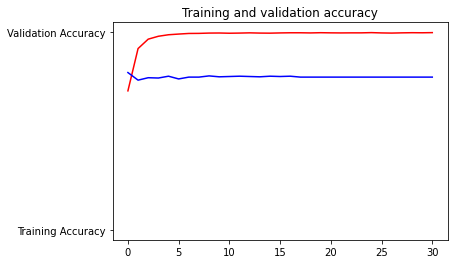

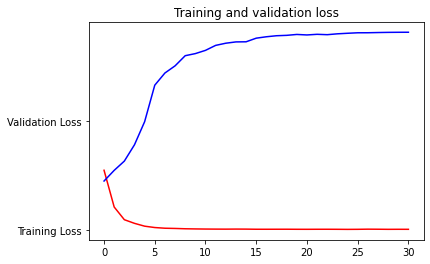

<Figure size 432x288 with 0 Axes>

In [36]:
# PLOTTING HISTORY OF FITTING
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs=range(len(acc))
plt.plot(epochs, acc, 'r', 'Training Accuracy')
plt.plot(epochs, val_acc, 'b', 'Validation Accuracy')
plt.title('Training and validation accuracy')
plt.figure()
plt.plot(epochs, loss, 'r', 'Training Loss')
plt.plot(epochs, val_loss, 'b', 'Validation Loss')
plt.title('Training and validation loss')

print("red is training, blue is validation")
plt.figure()

In [37]:
# SAVING MODEL
model.save('saved_models/' + model_name + '/' + model_variant + '.h5')

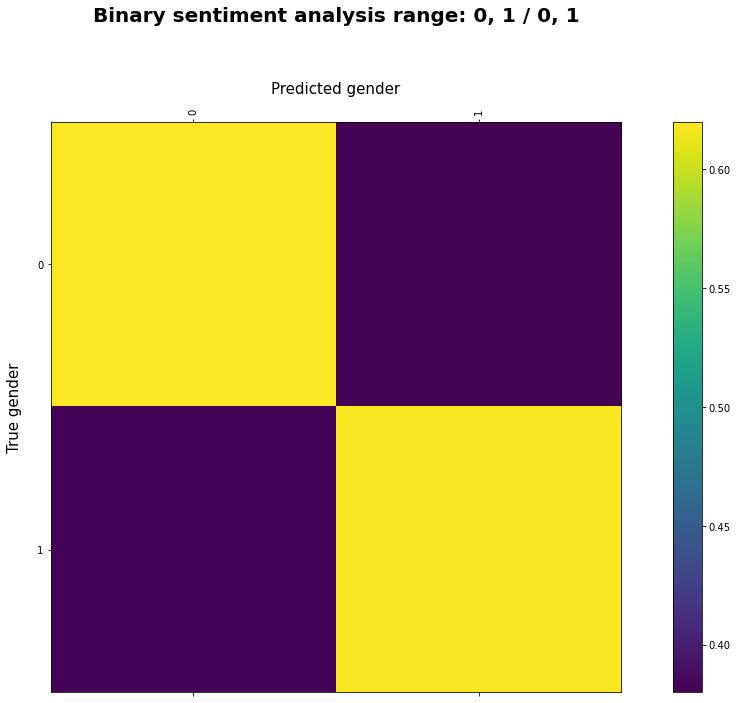

In [38]:
# PLOTTING CONFUSION MATRIX
y_pred = model.predict(X_test)
y_pred = y_pred.argmax(axis=-1)

y_test = np.array(y_test).flatten()
y_pred = y_pred.flatten()
cm = confusion_matrix(y_test, y_pred, normalize='true')

fig = plt.figure( figsize=[18.5,10.5])
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
ax.set_xlabel('Predicted gender', fontsize = 15, labelpad=15.0)
ax.xaxis.set_label_position('top')
ax.set_ylabel('True gender', fontsize = 15, labelpad=15.0)
ax.set_title('Binary sentiment analysis range: 0, 1 / 0, 1',fontweight="bold", size=20, pad=100.0)

cm_axis_vals = []

for x in np.unique(np.array(y_pred)):
    cm_axis_vals.append(x)

fig.colorbar(cax)
plt.xticks(range(2), cm_axis_vals, rotation=90)
plt.yticks(range(2), cm_axis_vals)
plt.show()

In [39]:
# PRINTING METRICS
from sklearn.metrics import classification_report
sentiment_vocab = ['M', 'F']

report = classification_report(y_test, y_pred, output_dict=True)
df_perf = pd.DataFrame.from_dict(report).transpose()
df_perf_2 = df_perf[:2]
df_perf_2.insert(loc=0, column='Gender', value=sentiment_vocab)
df_perf_2.precision = df_perf_2.precision.round(2)
df_perf_2.recall = df_perf_2.recall.round(2)
df_perf_2['f1-score'] = df_perf_2['f1-score'].round(2)
df_perf_2.support = df_perf_2.support.round()
df_perf_2.reset_index(drop=True, inplace=True)


df_perf_2

C:\Users\hanse\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pandas\core\generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
C:\Users\hanse\AppData\Local\Temp/ipykernel_26800/914610997.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_perf_2['f1-score'] = df_perf_2['f1-score'].round(2)


,Gender,precision,recall,f1-score,support
0,M,0.88,0.62,0.73,821.0
1,F,0.27,0.62,0.37,183.0
